# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import os
import sys 
import random
import time
import matplotlib.patches as mpatches
from multiprocessing import Pool
import multiprocessing as mp
from numpy.linalg import inv
from IPython.display import display, HTML
import webbrowser
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit, StratifiedKFold, GroupShuffleSplit,GroupKFold, StratifiedShuffleSplit)
from sklearn.model_selection import (GridSearchCV, cross_val_score,train_test_split, validation_curve,RandomizedSearchCV, learning_curve)
from sklearn import model_selection 
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.externals.joblib import dump
from sklearn.utils import shuffle
from sklearn.preprocessing import scale, RobustScaler, StandardScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor, MLPClassifier
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from utils import *

/home/soufiane/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


#  Data processing

In [2]:
df = pd.read_excel('5760_simple_discriptors-SMILES.xlsx')
data = df.drop([ 'Reaction_No', 'SMILES', 'Catalyst_1_Short_Hand','SMILES_R1','SMILES_R2','SMILES','SMILES_LI','SMILES_BASE','SMILES_SOLV'], axis=1 )
data_used = data.dropna(axis=0 , how='any')

# dropping missed values
data_used = data_used.reset_index().drop('index', axis=1).copy()

# Normalization of continuous variables 
data_used['Product_Yield_PCT_Area_UV'] = data_used['Product_Yield_PCT_Area_UV']/100

xls = pd.ExcelFile('Descriptors for Computational Modelling.xlsx')
df_Bases = pd.read_excel(xls, 'Base_Short_Hand')
df_Solvents = pd.read_excel(xls, 'Solvent_1_Short_Hand')
df_Ligands = pd.read_excel(xls, 'Ligand_Short_Hand')

# one hot encoding
data_ohe = data_cleaning(data_used)
Y_ohe = data_ohe["Product_Yield_PCT_Area_UV"]
data_ohe = data_ohe.drop('Product_Yield_PCT_Area_UV', axis=1)
X_ohe = pd.get_dummies(data_ohe)

# discreptors
data = data_discreptors(data_used,xls,df_Ligands,df_Bases,df_Solvents)
Y_just_descri = data["Product_Yield_PCT_Area_UV"]
df = data.drop(['Product_Yield_PCT_Area_UV',"Ligand_Short_Hand","Base_Short_Hand","Solvent_1_Short_Hand"], axis=1)
X_just_descri = pd.get_dummies(df)

In [3]:
help(data_cleaning)


Help on function data_cleaning in module utils:

data_cleaning(data_used)



In [4]:
data_ohe = data_cleaning(data_used)
Y_ohe = data_ohe["Product_Yield_PCT_Area_UV"]
data_ohe = data_ohe.drop('Product_Yield_PCT_Area_UV', axis=1)
X_ohe = pd.get_dummies(data_ohe)


data = data_discreptors(data_used,xls,df_Ligands,df_Bases,df_Solvents)
Y_just_descri = data["Product_Yield_PCT_Area_UV"]
df = data.drop(['Product_Yield_PCT_Area_UV',"Ligand_Short_Hand","Base_Short_Hand","Solvent_1_Short_Hand"], axis=1)
X_just_descri = pd.get_dummies(df)

# Modelling with descriptors

In [21]:
def fit_models(X_train, 
               X_test,
               y_train, 
               y_test,
               models=[]):
    predictions = []
    r2_values = []
    rmse_values = []
    for model in models:
        #print(model)
        # fit the model and generate predictions
        model.fit(X_train, y_train.ravel())
        preds = model.predict(X_test)

        # calculate an R-squared and RMSE values
        r_squared = r2_score(y_test, preds)
        rmse = mean_squared_error(y_test, preds) ** 0.5

        # append all to lists
        predictions.append(preds)
        r2_values.append(r_squared)
        rmse_values.append(rmse)
        #print(r_squared,rmse)
    print('Done fitting models')
    return predictions, r2_values, rmse_values

def plot_models(predictions,
                r2_values,
                rmse_values,
                y_test,
                titles =['Random Forest with [5 trees]',
                          'Random Forest with [50 trees]',
                          'Random Forest with [500 trees]',
                          'Neural Network [5 neurons]',
                          'Neural Network [50 neurons]',
                          'Neural Network [500 neurons]'],
                positions=[231,232,233,234,235,236], 
                save=False):

    fig = plt.figure(figsize=(15,10))
    for pos, pred, r2, rmse, title in zip( positions,
                                      predictions,
                                      r2_values,
                                      rmse_values,
                                      titles):
        # create subplot
        plt.subplot(pos)
        plt.grid(alpha=0.2)
        plt.title(title, fontsize=15)
        
        # add score patches
        r2_patch = mpatches.Patch(label="R2 = {:04.2f}".format(r2))
        rmse_patch = mpatches.Patch(label="RMSE = {:04.1f}".format(rmse))
        #plt.xlim(-25,105)
        #plt.ylim(0,105)
        plt.scatter(pred, y_test, alpha=0.2)
        plt.legend(handles=[r2_patch, rmse_patch], fontsize=12)
        plt.plot(np.arange(2), np.arange(2), ls="--", c=".3")
        fig.text(0.5, 0.08, 'predicted yield', ha='center', va='center', fontsize=15)
        fig.text(0.09, 0.5, 'observed yield', ha='center', va='center', rotation='vertical', fontsize=15)
    if save:
        plt.savefig(save, dpi = 300)
    plt.show()

In [22]:
models = [RandomForestRegressor(n_estimators=5),
          RandomForestRegressor(n_estimators=50),
          RandomForestRegressor(n_estimators=600),
          MLPRegressor(hidden_layer_sizes=(5),activation='tanh',solver='sgd', max_iter=100000),
          MLPRegressor(hidden_layer_sizes=(50),activation='tanh',solver='sgd', max_iter=100000),
          MLPRegressor(hidden_layer_sizes=(600),activation='tanh',solver='sgd', max_iter=100000)
         ]

X_train, X_test,y_train, y_test = train_test_split(X_just_descri, Y_just_descri, train_size=0.8)


preds, r2_values, rmse_values  = fit_models(X_train,
                                            X_test,
                                            y_train,
                                            y_test,
                                            models)

Done fitting models


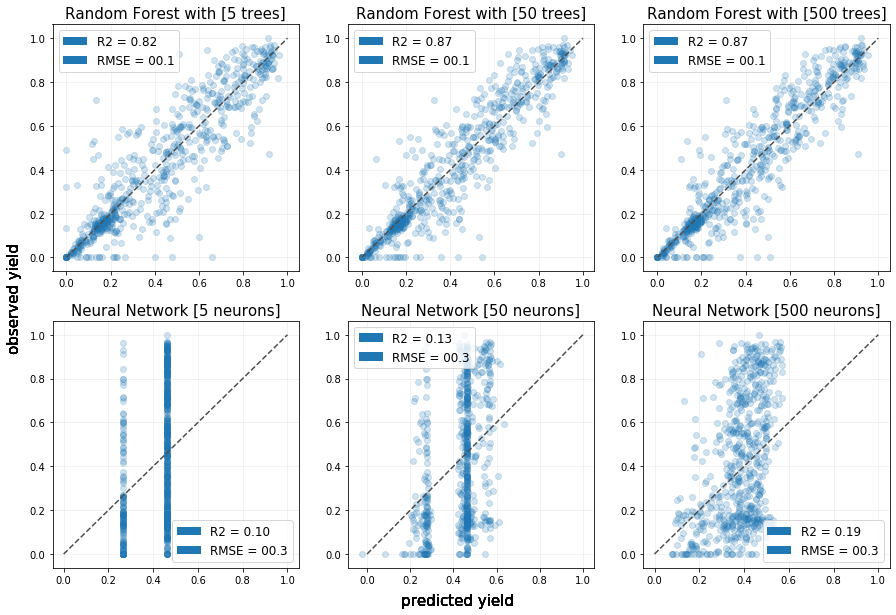

In [23]:
plot_models(preds,
            r2_values,
            rmse_values,
            y_test)

# Modelling with OHE

In [24]:
models = [RandomForestRegressor(n_estimators=5),
          RandomForestRegressor(n_estimators=50),
          RandomForestRegressor(n_estimators=600),
          MLPRegressor(hidden_layer_sizes=(5),activation='tanh',solver='sgd', max_iter=100000),
          MLPRegressor(hidden_layer_sizes=(50),activation='tanh',solver='sgd', max_iter=100000),
          MLPRegressor(hidden_layer_sizes=(600),activation='tanh',solver='sgd', max_iter=100000)
         ]

X_train, X_test,y_train, y_test = train_test_split(X_ohe, Y_ohe, train_size=0.8)


preds, r2_values, rmse_values  = fit_models(X_train,
                                            X_test,
                                            y_train,
                                            y_test,
                                            models)

Done fitting models


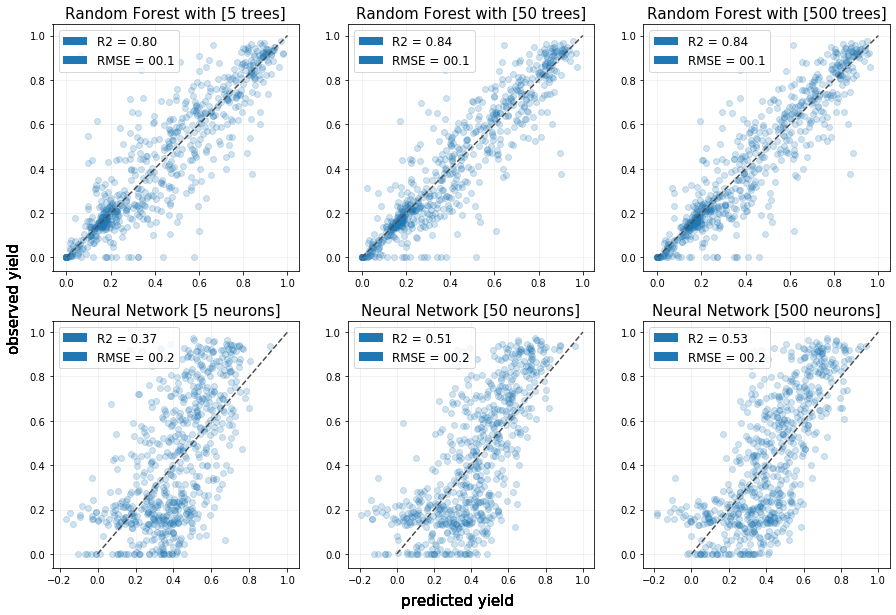

In [25]:
plot_models(preds,
            r2_values,
            rmse_values,
            y_test)